In [6]:
# Import required tools/tasks
from casatools import simulator, image, table, coordsys, measures, componentlist, quanta, ctsys
from casatasks import tclean, ft, imhead, listobs, exportfits, flagdata, bandpass, applycal, imstat, imval
from casatasks.private import simutil

import os
import pylab as pl
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS


# Instantiate all the required tools
sm = simulator()
ia = image()
tb = table()
cs = coordsys()
me = measures()
qa = quanta()
cl = componentlist()
mysu = simutil.simutil()

#definiing the data area
mydata='./'
ms_name='sim-flat-dnds-multi-pts.ms'

In [5]:
def plotData(msname=mydata+ms_name, myplot='uv'):
    """
    Options : myplot='uv'
              myplot='data_spectrum'
    """
    from matplotlib.collections import LineCollection
    tb.open(msname)

    # UV coverage plot
    if myplot=='uv':
        pl.figure(figsize=(4,4))
        pl.clf()
        uvw = tb.getcol('UVW')
        pl.plot( uvw[0], uvw[1], '.')
        pl.plot( -uvw[0], -uvw[1], '.')
        pl.title('UV Coverage')
    
    # Spectrum of chosen column. Make a linecollection out of each row in the MS.
    if myplot=='data_spectrum' or myplot=='corr_spectrum' or myplot=='resdata_spectrum'  or myplot=='rescorr_spectrum' or myplot=='model_spectrum':
        dats=None
        if myplot=='data_spectrum':
            dats = tb.getcol('DATA')
        if myplot=='corr_spectrum':
            dats = tb.getcol('CORRECTED_DATA')
        if myplot=='resdata_spectrum':
            dats = tb.getcol('DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='rescorr_spectrum':
            dats = tb.getcol('CORRECTED_DATA') - tb.getcol('MODEL_DATA') 
        if myplot=='model_spectrum':
            dats = tb.getcol('MODEL_DATA')
            
        xs = np.zeros((dats.shape[2],dats.shape[1]),'int')
        for chan in range(0,dats.shape[1]):
            xs[:,chan] = chan
    
        npl = dats.shape[0]
        fig, ax = pl.subplots(1,npl,figsize=(10,4))
        
        for pol in range(0,dats.shape[0]):
            x = xs
            y = np.abs(dats[pol,:,:]).T
            data = np.stack(( x,y ), axis=2)
            ax[pol].add_collection(LineCollection(data))
            ax[pol].set_title(myplot + ' \n pol '+str(pol))
            ax[pol].set_xlim(x.min(), x.max())
            ax[pol].set_ylim(y.min(), y.max())
        pl.show()


In [6]:
model_im='sim-flat-dnds-multi-pts'
# Display an image using AstroPy, with coordinate system rendering.
def dispAstropy(imname=mydata+model_im):
        exportfits(imagename=imname, fitsimage=imname+'.fits', overwrite=True)
        hdu = fits.open(imname+'.fits')[0]
        wcs = WCS(hdu.header,naxis=2)
        fig = pl.figure()
        fig.add_subplot(121, projection=wcs)
        pl.imshow(hdu.data[0,0,:,:], origin='lower', cmap=pl.cm.viridis)
        pl.xlabel('RA')
        pl.ylabel('Dec')


# Display an image cube or a single plane image.
# For a Cube, show the image at chan 0 and a spectrum at the location of the peak in chan0.
# For a Single plane image, show the image.
def dispImage(imname=mydata+model_im, useAstropy=False):
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()
    pl.figure(figsize=(10,4))
    pl.clf()
    if shp[3]>1:
        pl.subplot(121)
    if useAstropy==False:
        pl.imshow(pix[:,:,0,0]) 
        pl.title('Image from channel 0')
    else:
        dispAstropy(imname)
    if shp[3]>1:
        pl.subplot(122)
        ploc = np.where( pix == pix.max() )
        pl.plot(pix[ploc[0][0], ploc[1][0],0,:])
        pl.title('Spectrum at source peak')
        pl.xlabel('Channel')
        

In [42]:
def makeMSFrame(msname =mydata+ms_name):
    """ 
    Construct an empty Measurement Set that has the desired observation setup. 
    """
        
    os.system('rm -rf '+msname)
        
    ## Open the simulator
    sm.open(ms=msname);

    ## Read/create an antenna configuration. 
   
    antennalist = os.path.join( mydata ,"gmrt.cfg")

    (x,y,z,d,an,an2,telname, obspos) = mysu.readantenna(antennalist)

    ## Set the antenna configuration
    sm.setconfig(telescopename=telname,
                     x=x,
                     y=y,
                     z=z,
                     dishdiameter=d,
                     mount=['alt-az'], 
                     antname=an,
                     coordsystem='local',
                     referencelocation=me.observatory(telname));

    ## Set the polarization mode (this goes to the FEED subtable)
    sm.setfeed(mode='perfect R L', pol=['']);

    ## Set the spectral window and polarization (one data-description-id). 

    sm.setspwindow(spwname="UBand",
                   freq='300.0MHz',
                   deltafreq='390.625kHz', #R-- stands for frequency resolution
                   freqresolution='200.0MHz', #R-- stands for BW
                   nchannels=512,
                   stokes='RR LL');

    ## Setup source/field information (i.e. where the observation phase center is)
    
    sm.setfield( sourcename="fake",
                 sourcedirection=me.direction(rf='J2000', v0='05h35m17.5s',v1='-05d23m36s'));

    ## Set shadow/elevation limits (if you care). These set flags.
    sm.setlimits(shadowlimit=0.01, elevationlimit='17deg');

    ## Leave autocorrelations out of the MS.
    sm.setauto(autocorrwt=0.0);  


    sm.settimes(integrationtime='10s',
                usehourangle=True,
                referencetime=me.epoch('UTC','2017/01/09/12:27:23'));


    sm.observe(sourcename="fake",
               spwname='UBand', 
               starttime='0.0h', #R-- taking start time from negetive causes flip in uv plot
               stoptime='+6.0h');

    ## Close the simulator
    sm.close()
    

    flagdata(vis=msname,mode='unflag')                                                  

In [43]:
makeMSFrame()

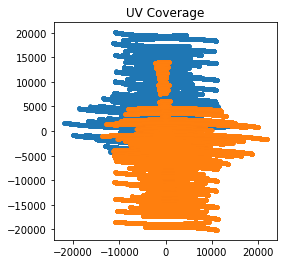

In [12]:
plotData(myplot='uv')

In [21]:
listobs(vis=mydata+'sim-flat-multi-pts.ms', listfile='obslist.txt', verbose=False, overwrite=True)
## print(os.popen('obslist.txt').read()) # ?permission denied?
fp = open('obslist.txt')
for aline in fp.readlines():
    print(aline.replace('\n',''))
fp.close()

           MeasurementSet Name:  /disk/Rashid/sim-band3/sim-fs-b3/sim-multi-pts/sim-flat-multi-pts.ms      MS Version 2
   Observer: CASA simulator     Project: CASA simulation  
Observation: GMRT(30 antennas)
Data records: 939600       Total elapsed time = 21600 seconds
   Observed from   09-Jan-2017/16:22:53.0   to   09-Jan-2017/22:22:53.0 (UTC)

Fields: 1
  ID   Code Name                RA               Decl           Epoch   SrcId      nRows
  0         fake                05:35:17.500000 -05.23.36.00000 J2000   0         939600
Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name   #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz)  Corrs  
  0      UBand    512   TOPO     300.000       390.625    200000.0    399.8047   RR  LL
Antennas: 30 'name'='station' 
   ID=   0-5: 'C00'='P', 'C01'='P', 'C02'='P', 'C03'='P', 'C04'='P', 'C05'='P', 
   ID=  6-11: 'C06'='P', 'C08'='P', 'C09'='P', 'C10'='P', 'C11'='P', 'C12'='P', 
   ID= 12-

In [8]:
def makeEmptyImage(imname_true=mydata+model_im):
    ## Define the center of the image
    radir = '05h35m17.5s'
    decdir = '-5d23m36s'
    
    ## Make the image from a shape
    ia.close()
    ia.fromshape(imname_true,[4096,4096,1,512],overwrite=True)
    
    ## Make a coordinate system
    cs=ia.coordsys()
    cs.setunits(['rad','rad','','Hz'])
    cell_rad=qa.convert(qa.quantity('0.4arcsec'),"rad")['value']
    cs.setincrement([-cell_rad,cell_rad],'direction')
    cs.setreferencevalue([qa.convert(radir,'rad')['value'],qa.convert(decdir,'rad')['value']],type="direction")
    cs.setreferencevalue('300.0MHz','spectral')
    cs.setreferencepixel([0],'spectral')
    cs.setincrement('390.625kHz','spectral')
    
    ## Set the coordinate system in the image
    ia.setcoordsys(cs.torecord())
    ia.setbrightnessunit("Jy/pixel")
    ia.set(0.0)
    ia.close() 

In [9]:
def makeCompList(clname_true, d, f):
    os.system('rm -rf '+clname_true)
    cl.done()
    cl.addcomponent(dir=d,#'J2000 5h35m17.5s -5d23m36s', 
                        flux=f,#0.00025,           
                        fluxunit='Jy', 
                        freq='400.0MHz', 
                        shape='point',       
                        spectrumtype="spectral index",
                        index=0.0)

    
    # Save the file
    cl.rename(filename=clname_true)
    cl.done()

In [10]:
def evalCompList(clname, imname=mydata+model_im):
    ##  Evaluate a component list
    cl.open(clname)
    ia.open(imname)
    ia.modify(cl.torecord(),subtract=False)
    ia.close()
    cl.done()

In [11]:
## Make an empty CASA image
makeEmptyImage()

In [13]:
import random

In [15]:
p=-0.6
smin=100
smax=2000
s0=200*p/((smin**p)-(smax**p))
def NS(s1, s2):
    N=s0*((s1**p)-(s2**p))/p
    return N

del_s=(np.log10(smax/smin))/10.
sintv=[]
for n in range(0,11):
    sintv.append(10**(np.log10(smin)+n*del_s))
N=[]
for s in range(0, len(sintv)-1):
    #print(sintv[s], sintv[s+1])
    N.append(round(NS(sintv[s], sintv[s+1])))
print(sum(N))
print(N)

print(sintv)

199
[39, 33, 28, 23, 19, 16, 13, 11, 9, 8]
[100.0, 134.9282847673563, 182.05642030260796, 245.64560522315819, 331.4454017339988, 447.213595499958, 603.4176336545162, 814.1810630738086, 1098.5605433061182, 1482.2688982138943, 2000.0000000000002]


In [16]:
flx=[]
for n in range(0,len(sintv)-1):
    num_samples = N[n]
    lower_limit = sintv[n]
    upper_limit = sintv[n+1]
    desired_mean = (sintv[n]+sintv[n+1])/2
    
# Generate random numbers with the desired mean
    random_numbers = np.random.uniform(lower_limit, upper_limit, num_samples)

# Adjust the generated numbers to have the desired mean
    mean_adjustment = desired_mean - np.mean(random_numbers)
    random_numbers += mean_adjustment
    flx.extend(random_numbers)
#    print("Generated random numbers:", random_numbers)
#    print("Calculated mean:", np.mean(random_numbers))


Generated random numbers: [126.99013492 115.40359831 108.85818628 100.89711391 128.92785113
 126.30222006 104.13448777 106.10445227 130.01230322 124.08163871
 120.16634905 108.85286744 116.23444439 128.02097312 106.1926045
 112.99816544 103.71176393 120.59413414 104.56187596 117.13183259
 108.68054495 126.35545055 129.3947468  129.73733682 112.52386456
 101.27921132 129.34838812 131.09256465 100.83581785 116.47485905
 116.05438005 104.53102207 121.63274812 116.50453295 125.61803294
 120.96779403 133.23309316 118.16836483 128.49180298]
Calculated mean: 117.46414238367815
Generated random numbers: [139.20566784 182.31175681 145.60293208 160.93356873 163.21220494
 138.45998565 146.36907363 179.72661353 169.86818494 149.77866692
 153.47109898 137.41978212 152.80416851 162.97215089 140.94957953
 160.67903185 172.00435013 176.13365901 166.1952316  150.62300715
 147.17062394 183.74727026 170.11161491 154.90500693 175.35899613
 159.30162361 152.49905917 142.94755443 151.0091899  145.2434392
 1

In [29]:
flux_jy.sort()

In [ ]:
pos=[]
for i in range(0, 199):
    x=random.randint(0, 4095)
    y=random.randint(0, 4095)
    box=box=str(x)+','+str(y)+','+str(x)+','+str(y)
    pos.append(imstat(imagename=mydata+model_im, box=box)['blcf'][:27])


In [ ]:
pf=list(zip(flux_jy, pos))


In [32]:
for s in pf:
    ## Make the component list
    makeCompList(clname_true='sim-new-flat-multi-pts_'+str(pf.index(s)+1)+'.cl', d=s[1], f=s[0])

    evalCompList(clname='sim-new-flat-multi-pts_'+str(pf.index(s)+1)+'.cl')


In [38]:
## Use an input model sky image - widefield gridders
def predictImager(msname=mydata+ms_name,
                  imname_true=mydata+model_im,
                  #'sim-flat-multi-pts.im',
                  gridder='widefield'):#'standard'):
    
    os.system('rm -rf sim_predict.*')
    
 
    tclean(vis=msname,
       startmodel=imname_true,
       imagename=mydata+'sim_predict',
       savemodel='modelcolumn',
       imsize=4096,
       cell='0.4arcsec',
       specmode='cube',
       interpolation='nearest',
       start='300.0MHz',
       width='390.665kHz',
       nchan=512,
       reffreq='399.8047MHz',
       gridder=gridder,
       normtype='flatsky', 
       cfcache='sim_predict.cfcache',
       wbawp=True,      
       pblimit=0.05,    
       conjbeams=False, 
       calcres=False, 
       calcpsf=True, 
       niter=0, 
       wprojplanes=-1)

In [39]:
### Copy visibilities from the MODEL column to the data columns
### This is required when predicting using tclean or ft as they will only write to the MODEL column
def copyModelToData(msname=mydata+ms_name):
    tb.open(msname,nomodify=False);
    moddata = tb.getcol(columnname='MODEL_DATA');
    tb.putcol(columnname='DATA',value=moddata);

    moddata.fill(0.0);
    tb.putcol(columnname='MODEL_DATA',value=moddata);
    tb.close();

In [44]:
predictImager()

In [45]:
copyModelToData()

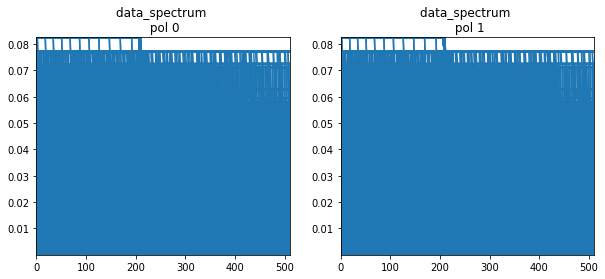

In [46]:
plotData(myplot='data_spectrum')

In [47]:
## Add Gaussian random noise 
def addNoiseSim(msname=mydata+ms_name):
    sm.openfromms(msname);
    sm.setseed(50)
    sm.setnoise(mode='simplenoise',simplenoise='0.25Jy');
    sm.corrupt();   
    sm.close();

In [48]:
addNoiseSim()